# Interface residue ML prediction. First attempt: Vanilla NN

## Load modules and packages

In [32]:
from sklearn import tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

from sklearn import datasets
from sklearn.decomposition import PCA
import random

In [34]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

## Load data, standard dictionaries and lists
Also:
- Removes empty columns from One-hot encoded target array. (Some standard residues in dict and list do not occur in dataset)
- Store an int version of One-hot encoded target array.
- Scale input features
- Split in training and test sets

In [35]:
res2num = {"ALA": 0, "ASX": 1, "CYS": 2, "ASP": 3, "GLU": 4, "PHE": 5, "GLY": 6, "HIS": 7,
 "ILE": 8, "LYS": 9, "LEU": 10, "MET": 11, "ASN": 12, "PRO": 13, "GLN": 14,
  "ARG": 15, "SER": 16, "THR": 17, "SEC": 18, "VAL": 19, "TRP": 20, "XAA": 21,
   "TYR": 22, "GLX": 23}

old_names = ["ALA", "ASX", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS",
 "ILE", "LYS", "LEU", "MET", "ASN", "PRO", "GLN",
  "ARG", "SER", "THR", "SEC", "VAL", "TRP", "XAA",
   "TYR", "GLX"]

In [388]:
# Load features and targets
X = np.load('../dataset/train_data.npy')
X_old = X
X = X.reshape(41656, 20, 26)

y = np.load('../dataset/train_target.npy')

# Select non zero from old_names using y first
nonzero_index = (~np.all(y == 0, axis = 0)).nonzero()[0]
names = []
for i in nonzero_index:
    names.append(old_names[i])
    
# Then remove zero columns from 'y'
y = y[:,~np.all(y == 0, axis = 0)]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_old)

In [74]:
y.shape

(41656, 20)

In [71]:
# Just check the ranges of features
feature_count =0
for i in range(X.shape[-1]):
    print(feature_count, np.min(X[:,:,i]), np.max(X[:,:,i]))
    feature_count+=1

0 -0.8015128 0.9993994
1 -0.41034156 0.24905394
2 -0.5892781 0.720381
3 -0.23654822 0.1295687
4 -0.53466487 0.72018224
5 -0.13521233 0.12933122
6 -0.20640847 0.5469364
7 -0.046667572 0.07426673
8 -0.0013560466 0.32913285
9 -0.011894988 0.025049854
10 -6.1537633 5.2891545
11 -8.37534 4.3254895
12 -4.877363 5.8385396
13 -3.6139503 5.2816205
14 -6.4477253 10.039461
15 -3.616955 3.8248384
16 -3.1959398 1.6784804
17 -3.8405879 2.4995637
18 -6.62389 4.885257
19 -3.1906435 2.8299987
20 -4.1435156 3.6247175
21 -3.8384352 2.7492971
22 -2.2655897 3.0932307
23 -3.123422 3.6290355
24 0.0 0.0
25 0.0 1.0


In [221]:
# Get integer values from one-hot encoding
y_int = np.array([])
for i in y:
    y_int = np.concatenate((y_int, np.nonzero(i)[0]))

# Save float and unique arrays of y_int
y_float = y_int.astype(np.float32)
unique_y = np.unique(y_float)

In [518]:
# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y_float, test_size=0.2, random_state=2)

In [39]:
X_temp_train = X_train.reshape(X_train.shape[0],520)
X_temp_test = X_test.reshape(X_test.shape[0],520)

## Basic EDA and visualisation
Can a simple tree-based machine learning algorithm predict the residue?

Can PCA or t-SNE already find a separation between data points? I.e., is there something distinguishing the point clouds complementary to residues that does not have to be "learned" during multiple irations?

Furthermore, what how frequently do the respective residue types occur at interfaces? One needs to deal with imbalances in the dataset.

In [40]:
X_temp_test.shape

(8332, 520)

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=15, random_state=0, class_weight= "balanced")
clf.fit(X_temp_train, y_train)

y_RF_pred = clf.predict(X_temp_test)

In [42]:
len(np.unique(y_RF_pred))

20

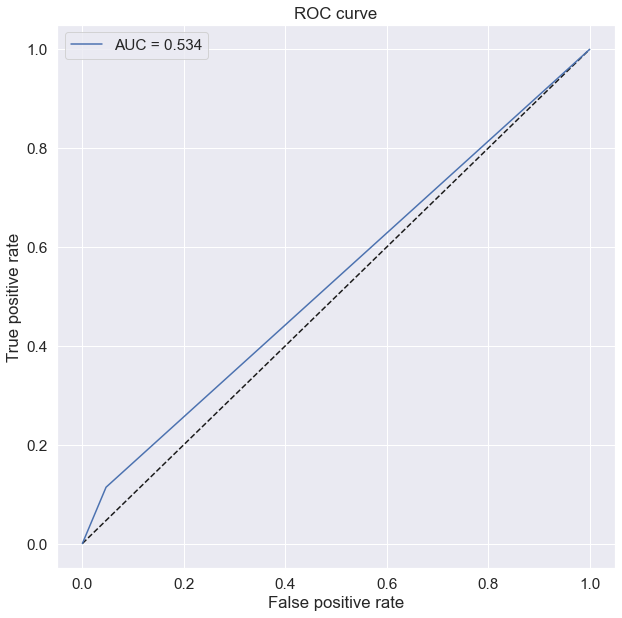

In [519]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()
y_RF_onehot = enc.fit_transform(y_RF_pred[:, np.newaxis]).toarray()
with torch.no_grad():
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_RF_onehot.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [520]:
pca = PCA(n_components=2)
X_r = pca.fit(X_scaled).transform(X_scaled)

print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.2113198  0.09282701]


In [521]:
rgb = []
for y in unique_y:
    col = (random.random(), random.random(), random.random())
    rgb.append(col)
colors = rgb

In [522]:
plt.figure()
lw = 2

<Figure size 432x288 with 0 Axes>

In [523]:
num2res = dict(zip(range(len(names)), names))
y_res_str = pd.Series(y_float).map(lambda x: num2res[x])

'Amino acid counts'

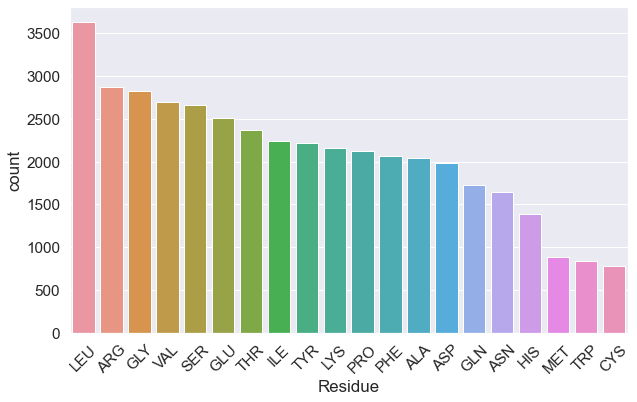

In [524]:
import seaborn as sns
plt.figure(figsize = (10,6))
df = pd.DataFrame(y_res_str)
df.rename(columns={0:'Residue'}, inplace=True)
sns.countplot(x='Residue', data = df, order = y_res_str.value_counts().index)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

g ="Amino acid counts"
g

Text(0.5, 1.0, 'PCA of Residue surface feature dataset')

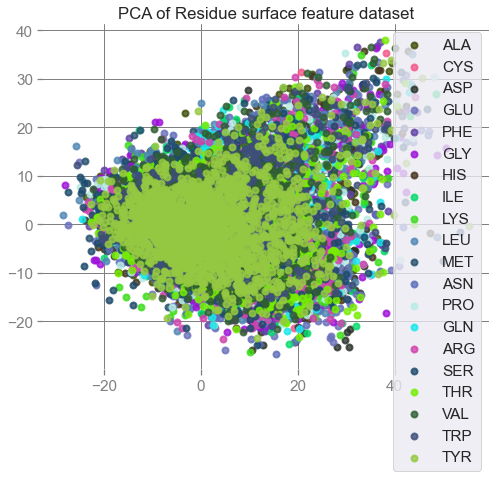

In [541]:
for color, i, name in zip(colors, unique_y, names[0:20]):
    plt.scatter(X_r[y_int == i, 0], X_r[y_int == i, 1], color = color, alpha=.8, lw=lw,
                label=name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of AA surface dataset')

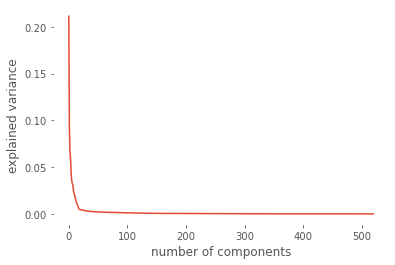

In [104]:
pca = PCA().fit(X_scaled)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance');

In [109]:
print(abs( pca.components_ ))

[[0.05919683 0.05728619 0.08158226 ... 0.02286414 0.         0.00010419]
 [0.07249426 0.07367052 0.05527684 ... 0.03618272 0.         0.00234577]]


In [129]:
# Add contibution of variables to two PC's and form a single array
contrib_arr = np.add(abs(pca.components_)[0], abs(pca.components_)[1])

In [210]:
indices = (-abs(contrib_arr)).argsort()[:80]

In [211]:
(indices < 260).sum()

50

/Users/maxjansen/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

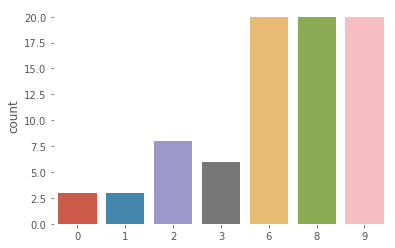

In [212]:
sns.countplot(indices%26)

<AxesSubplot:xlabel='Ranking', ylabel='Contribution'>

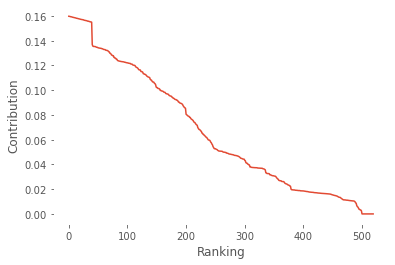

In [184]:
var_contribution = abs(np.sort(-contrib_arr))
var_pca_df = pd.DataFrame(zip(range(len(var_contribution)), var_contribution))
var_pca_df = var_pca_df.rename(columns={0:"Ranking",1:"Contribution"})
sns.lineplot(data=var_pca_df, x='Ranking', y='Contribution')

In [543]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(np.array(y_res_str)[i]), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [149]:
np.array(y_res_str)[2000]

'THR'

In [157]:
### TO DO ####
RS = 123
from sklearn.manifold import TSNE
fashion_tsne = TSNE(random_state=RS).fit_transform(X_scaled[0:5000])

In [ ]:
X_r.shape

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(3.9397109, 6.7484584, 'VAL'),
  Text(8.390176, 13.4645815, 'ASP'),
  Text(-6.863366, 5.8978224, 'GLU'),
  Text(-8.545076, 9.768686, 'TYR'),
  Text(-0.15669617, 1.7503777, 'ASP'),
  Text(3.4543211, 4.457132, 'ARG'),
  Text(-0.4121481, -0.56596607, 'ARG'),
  Text(1.8747689, 7.7084036, 'SER'),
  Text(-7.221509, -4.0304365, 'VAL'),
  Text(1.3822166, 5.9557223, 'LYS'),
  Text(3.1862822, 4.401058, 'GLY'),
  Text(-3.1678338, 2.0791383, 'MET'),
  Text(5.8422775, 6.7220926, 'ALA'),
  Text(-2.3183389, 7.1642733, 'GLN'),
  Text(-4.8378716, 5.0480895, 'ILE'),
  Text(0.5821933, -3.0065172, 'TYR'),
  Text(-1.5656296, 4.9622455, 'PHE'),
  Text(3.630933, 6.695655, 'THR'),
  Text(-4.595515, 3.612925, 'VAL'),
  Text(3.328591, 0.2654215, 'LEU')])

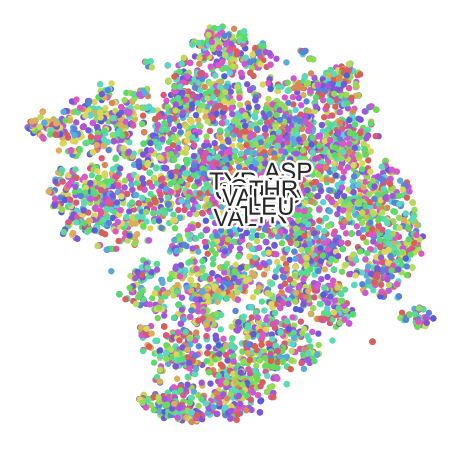

In [158]:
fashion_scatter(fashion_tsne, np.array(y_int[0:5000]))

In [415]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

In [526]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 130)
        self.layer2 = nn.Linear(130, 65)
        self.layer3 = nn.Linear(65, 20)
        
    def forward(self, x):
        x = x.view(-1, 20*26)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [527]:
class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count
res_weight = Variable(torch.from_numpy(weight)).float()


In [528]:
res_weight

tensor([0.0006, 0.0016, 0.0006, 0.0005, 0.0006, 0.0004, 0.0009, 0.0005, 0.0006,
        0.0003, 0.0014, 0.0008, 0.0006, 0.0007, 0.0004, 0.0005, 0.0005, 0.0005,
        0.0015, 0.0006])

In [529]:
model     = Model(X_train.shape[1]*X_train.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss(weight=res_weight)
model

Model(
  (layer1): Linear(in_features=520, out_features=130, bias=True)
  (layer2): Linear(in_features=130, out_features=65, bias=True)
  (layer3): Linear(in_features=65, out_features=20, bias=True)
)

In [530]:
import tqdm

EPOCHS  = 100
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

In [531]:
loss_list     = np.zeros((EPOCHS,))
loss_test_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


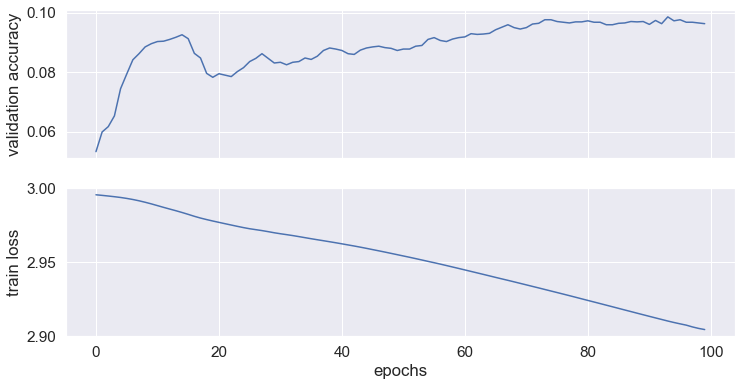

In [544]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("train loss")
ax2.set_xlabel("epochs");

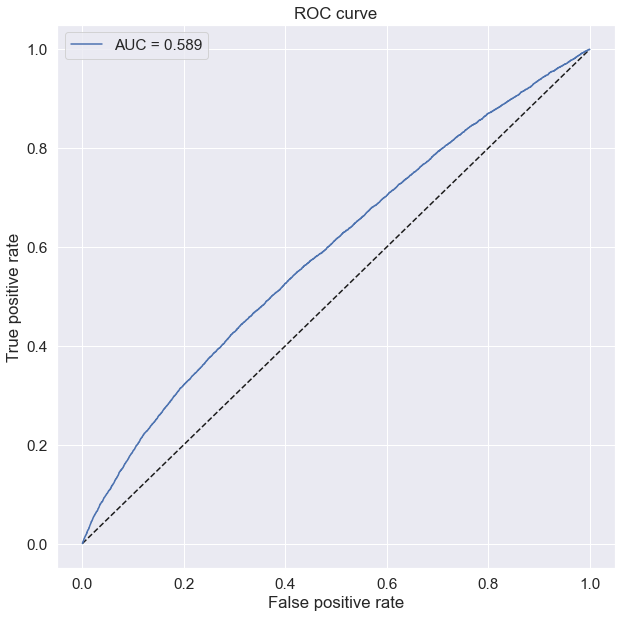

In [548]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [534]:
len(np.unique(y_test))

20

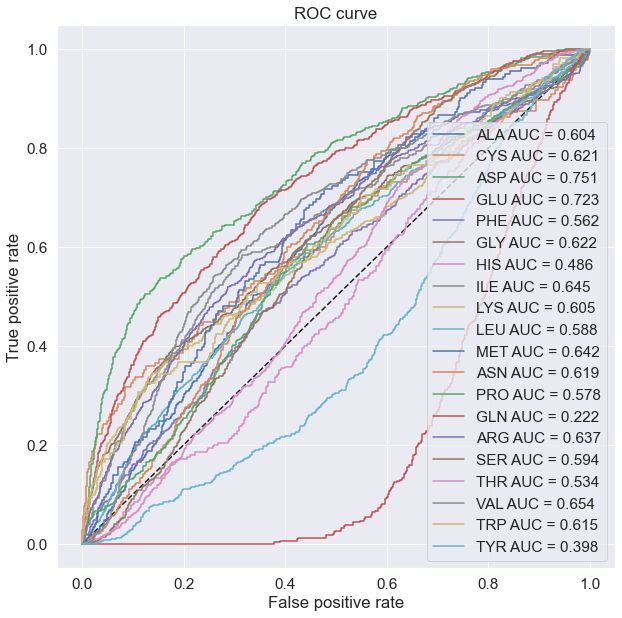

In [547]:
# Do a ROC plot for each amino acid
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()
for i in range(len(np.unique(y_test))):
    
    with torch.no_grad():
        y_pre = (model(X_test)[y_test == i]).numpy()
        Y_one = Y_onehot[y_test == i]
        fpr, tpr, threshold = roc_curve(Y_one.ravel(), y_pre.ravel())
    
    plt.plot(fpr, tpr, label=names[i] + ' AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [536]:
y_pred_max =np.zeros((len(y_pred),len(y_pred[0])))
for count,i in enumerate(y_pred):
    y_pred_max[count, np.argmax(i)] = 1

In [537]:
# One-hot to int
def onehot_int(one_hot):
    y_int = np.array([])
    for i in one_hot:
        y_int = np.concatenate((y_int, np.nonzero(i)[0]))
    return y_int

In [538]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(onehot_int(Y_onehot), onehot_int(y_pred_max))

In [545]:
def plot_confusion_matrix(data, labels):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    sns.set(color_codes=True)
    plt.figure(1, figsize=(14, 14))
 
    plt.title("Confusion Matrix")
 
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
    plt.close

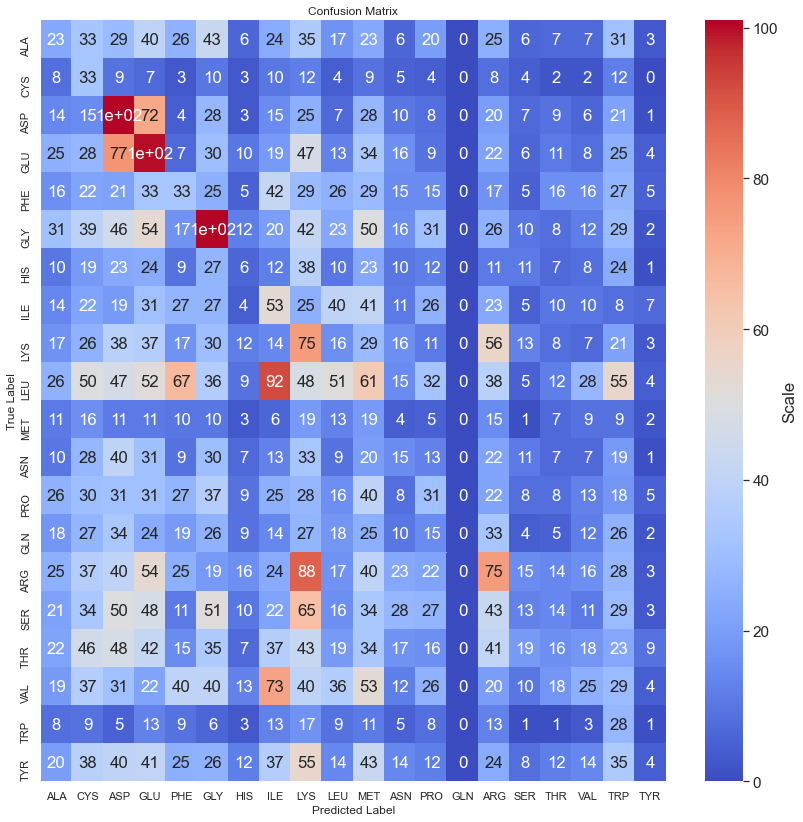

In [546]:
plot_confusion_matrix(cm, names)